In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from DecoderTrans import DecoderTransformer
from tokenizer import CurriculumTokenizer
from torch.nn.utils.rnn import pad_sequence
%matplotlib inline

In [2]:
# Загружаем данные
df = pd.read_csv('сurriculum_data.csv')

# Разделение на тренировочный и тестовый наборы
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Определение классов для работы с данными
class ExpressionDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.tokenizer = CurriculumTokenizer()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        expression = row['expression']
        result = row['result']
        
        # Преобразуем метку, вычитая минимальное значение метки
        result -= self.df['result'].min()  # Это приводит все метки к диапазону от 0 до N-1
        
        encoded_expression = self.tokenizer.encode(expression)
        return encoded_expression, result


# Создание объектов Dataset
train_dataset = ExpressionDataset(train_df)
val_dataset = ExpressionDataset(val_df)


def collate_batch(batch):
    expressions, results = zip(*batch)
    
    # Преобразуем каждое выражение в тензор
    expressions = [torch.tensor(expr) for expr in expressions]
    
    # Получаем длину каждого выражения
    lengths = [len(expr) for expr in expressions]
    
    # Паддим выражения
    padded_expressions = pad_sequence(expressions, batch_first=True, padding_value=0)
    
    # Преобразуем результаты в тензор
    results_tensor = torch.LongTensor(results)  # Тензор меток
    
    return padded_expressions, lengths, results_tensor



# Создание DataLoader с использованием функции collate_batch
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)

In [3]:
for batch in train_loader:
    print(batch)  # Печатаем весь batch, чтобы понять его структуру
    break  # Просто выводим первый батч, чтобы не выводить всё

def collate_batch(batch):
    expressions, results = zip(*batch)  # Разделяем выражения и результаты
    
    # Преобразуем каждое выражение в тензор
    expressions = [torch.tensor(expr) for expr in expressions]
    
    # Получаем длину каждого выражения
    lengths = [len(expr) for expr in expressions]  # Это можно использовать, если нужно
    
    # Паддим выражения
    padded_expressions = pad_sequence(expressions, batch_first=True, padding_value=0)
    
    # Преобразуем результаты в тензор
    results_tensor = torch.LongTensor(results)  # Тензор меток
    
    return padded_expressions, results_tensor

# Создаем DataLoader с collate_fn
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)


(tensor([[ 1, 13, 15,  3,  6,  3, 18, 12,  2,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  3, 19, 14,  3,  4,  3, 16, 14,  3,  3,  6,  3, 19, 12,  2],
        [ 1, 19, 18,  7, 12,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 16, 19,  3,  6,  3, 15, 14,  2,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  3, 18,  3,  4,  3, 11, 13,  3,  3,  6,  3, 13, 12,  2,  0],
        [ 1, 12, 12,  3,  6,  3, 17, 10,  2,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  3, 12, 17,  3,  4,  3, 12, 19,  3,  3,  6,  3, 15, 14,  2],
        [ 1, 11, 15,  3,  6,  3, 19, 12,  2,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 19, 19,  7, 12,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 15, 15,  3,  4,  3, 12, 11,  2,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 19, 12,  7, 12,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 16, 17,  7, 12,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 14, 17,  3,  5,  3, 14, 13,  2,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  3, 17, 17,  3,  4,  3, 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = DecoderTransformer(num_tokens=20, n_embd=128, num_layers=6, num_heads=8, num_classes=10).to(device)
num_classes = df['result'].max() - df['result'].min() + 1  # Подсчитываем количество классов
model = DecoderTransformer(num_tokens=20, n_embd=128, num_layers=6, num_heads=8, num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [5]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc="Training")
    for inputs, targets in pbar:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Если задача классификации, то выход имеет размерность [batch_size, num_classes]
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        pbar.set_postfix(loss=loss.item())
        
    accuracy = 100 * correct / total
    epoch_loss = total_loss / len(loader)
    return epoch_loss, accuracy


In [6]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(loader, desc="Evaluating")
        for inputs, lengths, targets in pbar:  # Теперь распаковываем три значения
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            pbar.set_postfix(loss=loss.item())
    accuracy = 100 * correct / total
    epoch_loss = total_loss / len(loader)
    return epoch_loss, accuracy


In [7]:
epochs = 10
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 8.1712, Train Acc: 0.29%
Val Loss: 7.4797, Val Acc: 0.27%

Epoch 2/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.7559, Train Acc: 0.38%
Val Loss: 7.6381, Val Acc: 0.27%

Epoch 3/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.6105, Train Acc: 0.40%
Val Loss: 7.6961, Val Acc: 0.27%

Epoch 4/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.5511, Train Acc: 0.45%
Val Loss: 7.7505, Val Acc: 0.82%

Epoch 5/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.5210, Train Acc: 0.41%
Val Loss: 7.8098, Val Acc: 0.48%

Epoch 6/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.5056, Train Acc: 0.45%
Val Loss: 7.8093, Val Acc: 0.48%

Epoch 7/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.4888, Train Acc: 0.36%
Val Loss: 7.8996, Val Acc: 0.55%

Epoch 8/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.4747, Train Acc: 0.38%
Val Loss: 7.8660, Val Acc: 0.69%

Epoch 9/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.4666, Train Acc: 0.53%
Val Loss: 7.8754, Val Acc: 0.82%

Epoch 10/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.4696, Train Acc: 0.34%
Val Loss: 7.8749, Val Acc: 0.34%


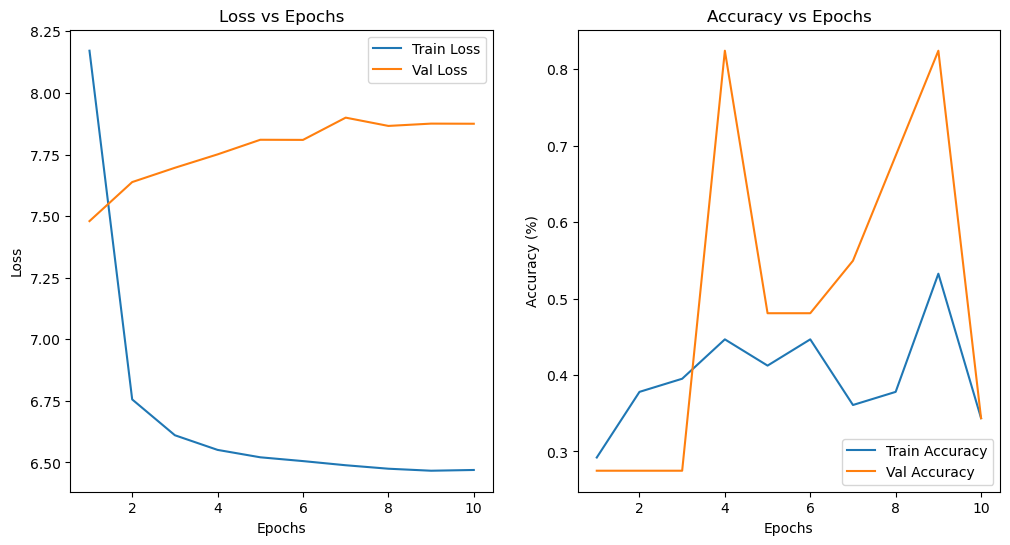

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.subplot(122)
plt.plot(range(1, epochs+1), train_accs, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accs, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy vs Epochs')
plt.show()


Random Sampling Epoch 1/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.4497, Train Acc: 0.41%
Val Loss: 7.8841, Val Acc: 0.82%

Random Sampling Epoch 2/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.4472, Train Acc: 0.57%
Val Loss: 7.9801, Val Acc: 0.82%

Random Sampling Epoch 3/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.4398, Train Acc: 0.46%
Val Loss: 7.9516, Val Acc: 0.82%

Random Sampling Epoch 4/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.4317, Train Acc: 0.57%
Val Loss: 7.9702, Val Acc: 0.69%

Random Sampling Epoch 5/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.4306, Train Acc: 0.50%
Val Loss: 8.0205, Val Acc: 0.82%

Random Sampling Epoch 6/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.4267, Train Acc: 0.48%
Val Loss: 8.0018, Val Acc: 0.82%

Random Sampling Epoch 7/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.8236, Train Acc: 0.53%
Val Loss: 8.4410, Val Acc: 0.48%

Random Sampling Epoch 8/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 7.0752, Train Acc: 0.50%
Val Loss: 8.3989, Val Acc: 0.69%

Random Sampling Epoch 9/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 7.0372, Train Acc: 0.53%
Val Loss: 8.5324, Val Acc: 0.48%

Random Sampling Epoch 10/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 7.0241, Train Acc: 0.52%
Val Loss: 8.4729, Val Acc: 0.48%

Curriculum Learning Epoch 1/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 7.0227, Train Acc: 0.48%
Val Loss: 8.5122, Val Acc: 0.48%

Curriculum Learning Epoch 2/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 7.0144, Train Acc: 0.43%
Val Loss: 8.5108, Val Acc: 0.48%

Curriculum Learning Epoch 3/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 7.0118, Train Acc: 0.50%
Val Loss: 8.5805, Val Acc: 0.69%

Curriculum Learning Epoch 4/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.9806, Train Acc: 0.41%
Val Loss: 8.5674, Val Acc: 0.48%

Curriculum Learning Epoch 5/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.9055, Train Acc: 0.40%
Val Loss: 8.7357, Val Acc: 0.07%

Curriculum Learning Epoch 6/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.8443, Train Acc: 0.43%
Val Loss: 8.8836, Val Acc: 0.48%

Curriculum Learning Epoch 7/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.7765, Train Acc: 0.46%
Val Loss: 9.0753, Val Acc: 0.48%

Curriculum Learning Epoch 8/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.7319, Train Acc: 0.50%
Val Loss: 9.1720, Val Acc: 0.48%

Curriculum Learning Epoch 9/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.6986, Train Acc: 0.55%
Val Loss: 9.3758, Val Acc: 0.48%

Curriculum Learning Epoch 10/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.7716, Train Acc: 0.34%
Val Loss: 9.1864, Val Acc: 0.48%


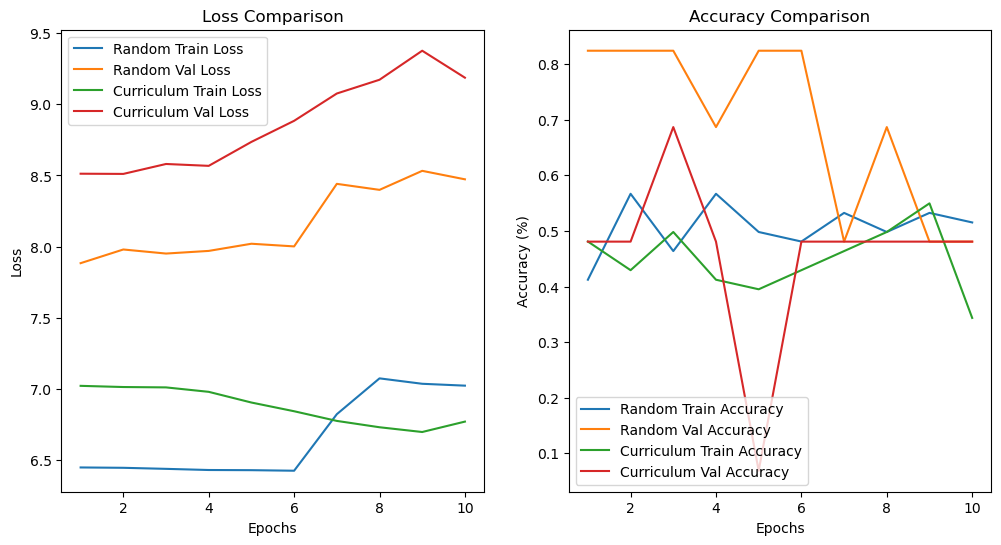

In [9]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Случайное сэмплирование (обучение с случайным сэмплированием)
def train_random_sampling():
    random_train_losses, random_val_losses = [], []
    random_train_accs, random_val_accs = [], []
    
    for epoch in range(epochs):
        print(f"\nRandom Sampling Epoch {epoch+1}/{epochs}")
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        random_train_losses.append(train_loss)
        random_train_accs.append(train_acc)
        random_val_losses.append(val_loss)
        random_val_accs.append(val_acc)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    return random_train_losses, random_val_losses, random_train_accs, random_val_accs

# Curriculum learning (обучение с curriculum learning)
def train_curriculum_learning():
    # Используем измененный порядок данных
    curriculum_train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)
    
    curriculum_train_losses, curriculum_val_losses = [], []
    curriculum_train_accs, curriculum_val_accs = [], []
    
    for epoch in range(epochs):
        print(f"\nCurriculum Learning Epoch {epoch+1}/{epochs}")
        train_loss, train_acc = train_epoch(model, curriculum_train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        curriculum_train_losses.append(train_loss)
        curriculum_train_accs.append(train_acc)
        curriculum_val_losses.append(val_loss)
        curriculum_val_accs.append(val_acc)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    return curriculum_train_losses, curriculum_val_losses, curriculum_train_accs, curriculum_val_accs

# Запуск экспериментов
random_train_losses, random_val_losses, random_train_accs, random_val_accs = train_random_sampling()
curriculum_train_losses, curriculum_val_losses, curriculum_train_accs, curriculum_val_accs = train_curriculum_learning()

# Визуализация потерь
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(range(1, epochs+1), random_train_losses, label='Random Train Loss')
plt.plot(range(1, epochs+1), random_val_losses, label='Random Val Loss')
plt.plot(range(1, epochs+1), curriculum_train_losses, label='Curriculum Train Loss')
plt.plot(range(1, epochs+1), curriculum_val_losses, label='Curriculum Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Comparison')

# Визуализация точности
plt.subplot(122)
plt.plot(range(1, epochs+1), random_train_accs, label='Random Train Accuracy')
plt.plot(range(1, epochs+1), random_val_accs, label='Random Val Accuracy')
plt.plot(range(1, epochs+1), curriculum_train_accs, label='Curriculum Train Accuracy')
plt.plot(range(1, epochs+1), curriculum_val_accs, label='Curriculum Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Comparison')

plt.show()
